In [37]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers
import time

In [38]:
class GAN:
    def __init__(self):
        self.latent_dim = 100
        self.generator_vector_size = 8
        self.discriminator_input_shape = (self.generator_vector_size,)
        self.num_examples_to_generate = 16

        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.gan = self.combime_gan(self.generator, self.discriminator)

    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # connect generator and discriminator
        model = tf.keras.Sequential()
        model.add(g_model)
        model.add(d_model)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(64, use_bias=True, input_dim=self.latent_dim))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(32))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(self.generator_vector_size, activation='tanh'))

        model.summary()
        return model

        # noise = tf.keras.layers.Input(shape=(self.latent_dim,))
        # g_rows = model(noise)
        # return tf.keras.Model(noise, g_rows)
        # return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(32, use_bias=True, input_shape=self.discriminator_input_shape))
        # model.add(layers.Dense(32, use_bias=False, input_shape=(8,)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

        model.add(layers.Dense(16))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model

        # g_rows = tf.keras.layers.Input(shape=self.discriminator_input_shape)
        # validity = model(g_rows)
        # return tf.keras.Model(g_rows, validity)


    def train(self, df, epochs, batch_size=8):
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)
        X_train = df.values
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))

        for i, epoch in enumerate(range(epochs)):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            rows = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_rows = self.generator.predict(noise)
            d_loss_real, d_acc_real = self.discriminator.train_on_batch(rows, valid)
            d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(gen_rows, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_acc = 0.5 * np.add(d_acc_real, d_acc_fake)

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            g_loss, g_acc = self.gan.train_on_batch(noise, valid)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
            # if epoch % 10 == 0:
            #   noise = np.random.normal(0, 1, (1, self.noise_dim))
            #   gen_rows = self.generator.predict(noise)
            #   print(gen_rows)
        return d_losses, d_accuracies, g_losses, g_accuracies

In [39]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/diabetes.arff')

In [41]:
diab_df = pd.DataFrame(diab_arf[0])

In [42]:
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [43]:
diab_df['class'].value_counts()

b'tested_negative'    500
b'tested_positive'    268
Name: class, dtype: int64

In [44]:
# diab_df.replace(to_replace=b'tested_negative', value=-1, inplace=True)
# diab_df.replace(to_replace=b'tested_positive', value=1, inplace=True)

In [45]:
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [46]:
# the values must be scaled to the range [-1,1] to match the output of the generator model
def scaler(df):
  for column in df:
    max = df[column].max()
    min = df[column].min()
    col = 2*((df[column] - min)/(max - min)) - 1
    df[column] = col
  return df

In [47]:
# class is not part of sample description
del diab_df['class']
diab_df = scaler(diab_df)

In [48]:
diab_df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591970
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858454,-0.900000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333
75%,-0.294118,0.409548,0.311475,-0.353535,-0.699173,0.090909,-0.531810,-0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
gan = GAN()
(d_losses, d_accuracies, g_losses, g_accuracies) = gan.train(df=diab_df, epochs=1000, batch_size=16)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                6464      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


0 [D loss: 0.686516, acc.: 56.25%] [G loss: 0.827427, acc.: 0.44%]
1 [D loss: 0.714848, acc.: 50.00%] [G loss: 0.774248, acc.: 0.38%]
2 [D loss: 0.700365, acc.: 50.00%] [G loss: 0.803129, acc.: 0.31%]
3 [D loss: 0.692721, acc.: 50.00%] [G loss: 0.793221, acc.: 0.50%]
4 [D loss: 0.669194, acc.: 62.50%] [G loss: 0.782301, acc.: 0.44%]
5 [D loss: 0.642103, acc.: 62.50%] [G loss: 0.826276, acc.: 0.31%]
6 [D loss: 0.696889, acc.: 50.00%] [G loss: 0.848419, acc.: 0.25%]
7 [D loss: 0.761167, acc.: 43.75%] [G loss: 0.851431, acc.: 0.31%]
8 [D loss: 0.724252, acc.: 50.00%] [G loss: 0.878707, acc.: 0.38%]
9 [D loss: 0.731370, acc.: 50.00%] [G loss: 0.811183, acc.: 0.25%]
10 [D loss: 0.741369, acc.: 34.38%] [G loss: 0.738182, acc.: 0.50%]
11 [D loss: 0.726250, acc.: 50.00%] [G loss: 0.789393, acc.: 0.62%]
12 [D loss: 0.671024, acc.: 56.25%] [G loss: 0.794192, acc.: 0.44%]
13 [D loss: 0.676730, acc.: 56.25%] [G loss: 0.791438, acc.: 0.31%]
14 [D loss: 0.698831, acc.: 50.00%] [G loss: 0.815035, acc

In [50]:
import matplotlib.pyplot as plt
def show_plot(arr):
  x = range(arr.shape[0])
  plt.plot(x, arr)

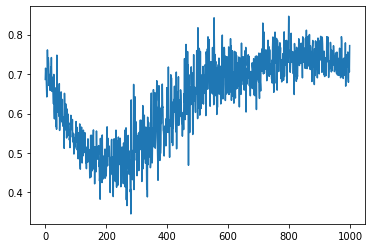

In [51]:
show_plot(d_losses)

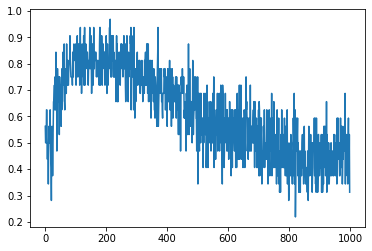

In [52]:
show_plot(d_accuracies)

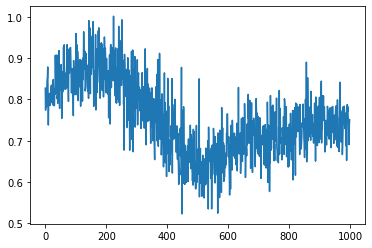

In [53]:
show_plot(g_losses)

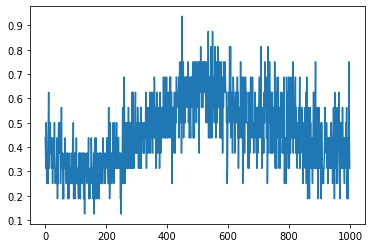

In [54]:
show_plot(g_accuracies)